# LCP module B - exercise 03
### Daniele Ninni
#### AY 2021/22, UniPD

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%run plot.py

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

### Read data corresponding to various amplitudes

In [ ]:
def reader(plot=True,dim=2,Z=12,A=500,N=10000,L=60,DX=50,bias=5):
    str0 = f'ts_L{L}_Z{Z}_A{A}_DX{DX}_bias{bias}_N{N}.dat'
    print('Reading', str0, '...')
    fnamex='DATA/x_'+str0
    fnamey='DATA/y_'+str0

    x = np.loadtxt(fnamex,delimiter=" ",dtype=float)
    x = x.reshape((N,L,dim))
    if plot == True:
        Show_data(x,L,"data from file",nsegments=6)

    categ = np.loadtxt(fnamey,dtype=int)
    n_class = 3 # y.argmax()-y.argmin()+1
    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1.

    print('Done!')
    return x,y,n_class

### Rescale data, split train/val.

In [ ]:
def data_preprocess(x,y,n_class,plot=True,dim=2,Z=12,A=500,N=10000,L=60,DX=50,bias=5):
    # FIRST PASSAGE: DO NOT DO THIS --> FAILURE 
    #
    # remove average value of each sample from its values
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]

    # SECOND PASSAGE: DO NOT DO THIS --> ALSO FAILURE 
    #
    # rescale (crude version, variance should be used)
    x = x/400
        
    if plot == True:    
        Show_data(x,L,"rescaled data",nsegments=6)

    perc_train = 0.8
    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)
    #print(f'A={A}, N_train={N_train}, N_val={N_val}, L={L}, n_class={n_class}')

    #x_train = x_train.astype("float32")
    #y_train = y_train.astype("float32")
    #x_val = x_val.astype("float32")
    #y_val = y_val.astype("float32")

    x_train = x_train.reshape(x_train.shape[0],L,dim)
    x_val =  x_val.reshape(x_val.shape[0],L,dim)

    return x_train,y_train,x_val,y_val

### Convolutional NN

In [ ]:
param = {'dim':2, 'Z':12, 'A':500, 'N':10000, 'L':60, 'DX':50, 'bias':5}
locals().update(param)

input_shape = (L, dim)
n_class = 3

# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

# from keras import regularizers, initializers

reg = tf.keras.regularizers.l2(0.2) # raised to 0.2
#reg = regularizers.l1(0.1)
ini = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.05,seed=None)
NCONV = 1
NF = 5

# challenge: at most 600 tunable parameters
model = Sequential()
# 
if NCONV == 1:
    # -----1-----
    model.add(Conv1D(filters=NF,
                     kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5,
                     kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12,activation='relu'))
    model.add(Dropout(0.2))
# 
if NCONV == 2:
    # -----2-----
    model.add(Conv1D(filters=NF,
                     kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg, # TRY WITHOUT!
                     activation='relu',
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Flatten())
    model.add(Dense(9,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6,activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(10,activation='relu'))
    #model.add(Dropout(0.3))
model.add(Dense(n_class,activation='softmax')) # softmax!

print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01,momentum=0.9,nesterov=True) # decay=1e-6
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

----- Model 1 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 5)             115       
                                                                 
 average_pooling1d (AverageP  (None, 10, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 12)                252       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                    

In [ ]:
model.layers

### Define function that plots weights

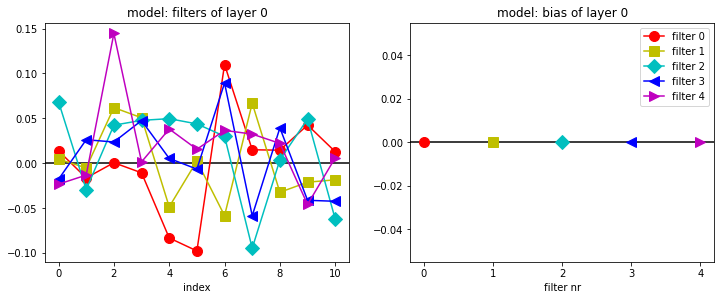

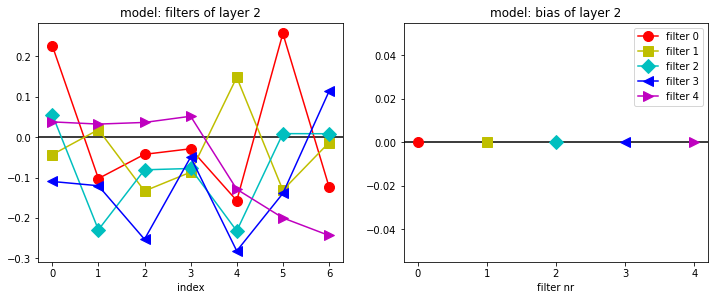

In [ ]:
def Show_weights(model,l=0,label="model"):
    c = ['r','y','c','b','m']
    m = ['o','s','D','<','>']
    ms = 10
    
    w = model.layers[l].get_weights()[0]
    wT = w.T
    M = len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX = plt.subplots(1,2,figsize=(12,4.4))
    ax = AX[0]
    ax.axhline(0,c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax = AX[1]
    ax.axhline(0,c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

### Train the NN using data corresponding to various amplitudes

In [ ]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!
BATCH_SIZE = 250
EPOCHS = 100

train_acc,val_acc = [],[]
amplitudes = range(50,1001,50)
for ampl in amplitudes:

    param = {'dim':2, 'Z':12, 'A':ampl, 'N':10000, 'L':60, 'DX':50, 'bias':5}
    x,y,n_class = reader(plot=False,**param)
    x_train,y_train,x_val,y_val = data_preprocess(x,y,n_class,plot=False,**param)

    print('----- Model',NCONV,'-----\nFITTING ...')
    fit = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0,
                    shuffle=True)
    train_acc.append(fit.history['accuracy'][-1])
    val_acc.append(fit.history['val_accuracy'][-1])

    print('DONE!\n')

Reading ts_L60_Z12_A50_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A100_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A150_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A200_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A250_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A300_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A350_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A400_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A450_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A500_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
DONE!

Reading ts_L60_Z12_A550_DX50_bias5_N10000.dat ...
D

### Results of the training

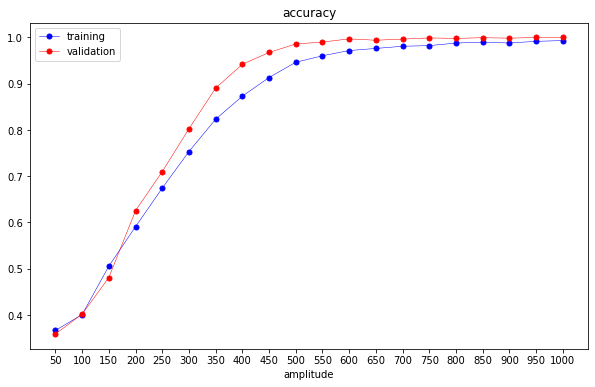

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(amplitudes, train_acc, linewidth=.5, color='blue', marker='o', markersize=5, label='training')
ax.plot(amplitudes, val_acc,   linewidth=.5, color='red',  marker='o', markersize=5, label='validation')
ax.set_xticks(amplitudes)
ax.set_xlabel('amplitude')
ax.set_title('accuracy')
ax.legend()
plt.show()

| Amplitude | Training accuracy | Validation accuracy |
| :-: | :-: | :-: |
|   50 | 0.3666 | 0.3590 |
|  100 | 0.4010 | 0.4020 |
|  150 | 0.5056 | 0.4810 |
|  200 | 0.5910 | 0.6255 |
|  250 | 0.6743 | 0.7100 |
|  300 | 0.7534 | 0.8025 |
|  350 | 0.8232 | 0.8905 |
|  400 | 0.8730 | 0.9420 |
|  450 | 0.9134 | 0.9675 |
|  500 | 0.9464 | 0.9860 |
|  550 | 0.9604 | 0.9900 |
|  600 | 0.9718 | 0.9970 |
|  650 | 0.9762 | 0.9940 |
|  700 | 0.9810 | 0.9965 |
|  750 | 0.9824 | 0.9990 |
|  800 | 0.9879 | 0.9980 |
|  850 | 0.9900 | 0.9995 |
|  900 | 0.9880 | 0.9985 |
|  950 | 0.9916 | 1.0000 |
| 1000 | 0.9933 | 1.0000 |

### Define function that shows history of the training

In [ ]:
def Show_history(fit):
    fig,AX = plt.subplots(1,2,figsize=(12,5.))
    ax = AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0,1])
    ax.legend()
    ax = AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0,1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

### Train the NN using data corresponding to a particular amplitude

Reading ts_L60_Z12_A500_DX50_bias5_N10000.dat ...
Done!
----- Model 1 -----
FITTING ...
Epoch 1/100
32/32 - 0s - loss: 0.1987 - accuracy: 0.9352 - val_loss: 0.0599 - val_accuracy: 0.9820 - 251ms/epoch - 8ms/step
Epoch 2/100
32/32 - 0s - loss: 0.1295 - accuracy: 0.9569 - val_loss: 0.0437 - val_accuracy: 0.9875 - 258ms/epoch - 8ms/step
Epoch 3/100
32/32 - 0s - loss: 0.1051 - accuracy: 0.9644 - val_loss: 0.0460 - val_accuracy: 0.9880 - 258ms/epoch - 8ms/step
Epoch 4/100
32/32 - 0s - loss: 0.1118 - accuracy: 0.9616 - val_loss: 0.0486 - val_accuracy: 0.9875 - 253ms/epoch - 8ms/step
Epoch 5/100
32/32 - 0s - loss: 0.1009 - accuracy: 0.9670 - val_loss: 0.0394 - val_accuracy: 0.9905 - 257ms/epoch - 8ms/step
Epoch 6/100
32/32 - 0s - loss: 0.1004 - accuracy: 0.9674 - val_loss: 0.0409 - val_accuracy: 0.9910 - 245ms/epoch - 8ms/step
Epoch 7/100
32/32 - 0s - loss: 0.1016 - accuracy: 0.9671 - val_loss: 0.0426 - val_accuracy: 0.9885 - 259ms/epoch - 8ms/step
Epoch 8/100
32/32 - 0s - loss: 0.0996 - accu

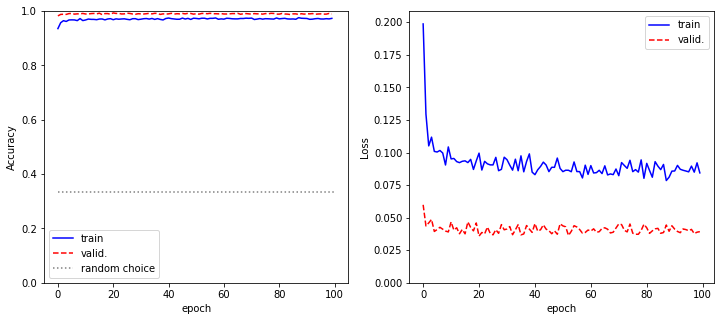

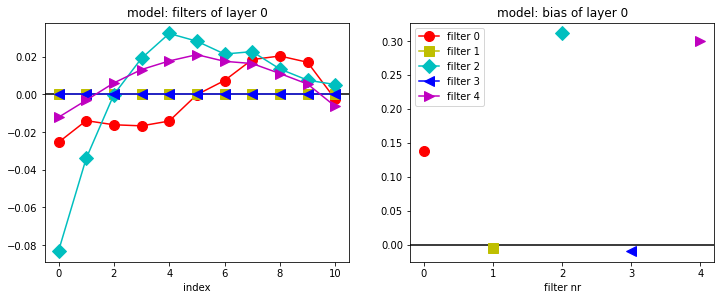

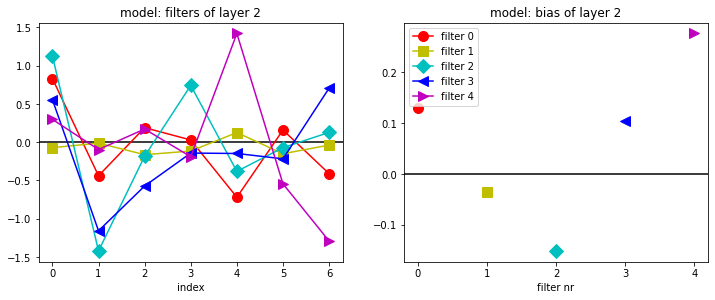

In [ ]:
ampl = 500 # sample amplitude
param = {'dim':2, 'Z':12, 'A':ampl, 'N':10000, 'L':60, 'DX':50, 'bias':5}
x,y,n_class = reader(plot=False,**param)
x_train,y_train,x_val,y_val = data_preprocess(x,y,n_class,plot=False,**param)

print('----- Model',NCONV,'-----\nFITTING ...')
fit = model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val,y_val),
                verbose=2,
                shuffle=True)
print('DONE!\n')

Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

### Confusion matrix

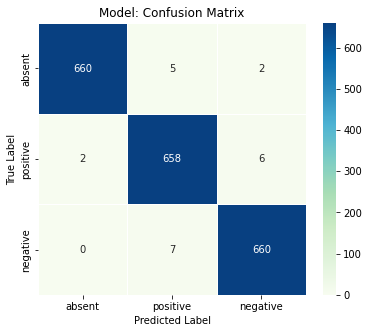

In [ ]:
import seaborn 
from sklearn import metrics

LABELS = ["absent","positive","negative"]
cmap = "GnBu"

def show_confusion_matrix(validations,predictions,label="Model"):
    matrix = metrics.confusion_matrix(validations,predictions)
    plt.figure(figsize=(6,5))
    seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val,axis=1)
max_y_val = np.argmax(y_val,axis=1)

show_confusion_matrix(max_y_val,max_y_pred_val)

End of part 2.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d991341-85e0-460c-ac0b-888d6f039546' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>